In [1]:
"""
In notebook we will discuss basic concepts of Self-Improvise Rag
"""

'\nIn notebook we will discuss basic concepts of Self-Improvise Rag\n'

In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir("../..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures


In [3]:
from src.utils import get_llm, get_embedder
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
import asyncio
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from uuid import uuid4
from langchain_core.documents import Document
import nltk

nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from pydantic import BaseModel, Field
from typing import Literal, List, Optional, Dict, Any
from langchain_core.prompts import ChatPromptTemplate
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display

USER_AGENT environment variable not set, consider setting it to identify your requests.
/anaconda/envs/unstructured_seed_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
from dotenv import load_dotenv

load_dotenv()

True

#### Using AzureChatOpenAI and AzureOpenAIEmbeddings
This section demonstrates how to instantiate and test AzureChatOpenAI and AzureOpenAIEmbeddings using utility functions.

In [5]:
# Instantiate AzureChatOpenAI
llm = get_llm()
# print(llm)

In [6]:
# # Test AzureChatOpenAI with a simple prompt
# response = llm.invoke("Hello, who are you?")
# print(response)

In [7]:
# Instantiate AzureOpenAIEmbeddings
embedder = get_embedder()
# print(embedder)

In [8]:
# # Test AzureOpenAIEmbeddings with a sample text
# embedding = embedder.embed_query("This is a test sentence for embedding.")
# print(embedding[:10])  # Print first 10 values for brevity

### Next we populate vector db with some online resources
- Step 1: Use url loader to fetch data from a URLs 
- Step 2: Use text splitter to split the data into smaller chunks
- Step 3: Create summarization chain to summarize the data by source and add to the metadata
- Step 4: Add basic keyword extractor and extract keywords and add to the metadata
- Step 5: Create embeddings using AzureOpenAIEmbeddings
- Step 6: Create vector store using milvius/faiss
- Step 7: Create retriever using the vector store
- Step 8: Application of BM25 hybrid retriever along with the vector store retriever

In [9]:
urls = [
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-march-2025",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-february-2025",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-january-2025",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-december-2024",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-november-2024",
    "https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-october-2024",
]

In [10]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [11]:
docs_list

[Document(metadata={'source': 'https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-march-2025', 'title': 'Nutmeg investor update: March 2025 - Nutmeg', 'description': 'February was a busy month, with investors digesting a lot of geopolitical news. US stocks fell back, but European and Chinese equities made notable gains.', 'language': 'en'}, page_content="Nutmeg investor update: March 2025 - NutmegSkip to contentProductsProductsInvest for every stage for life and make the most of your tax allowances.\xa0Stocks and Shares ISAPersonal PensionLifetime ISAJunior ISAGeneral Investment AccountInvestment stylesInvestment stylesHave your money managed in a way that fits your goals and\xa0priorities.Fully ManagedThematic InvestingSmart AlphaSocially Responsible InvestingFixed AllocationAdviceFinancial advice and guidanceGet expert support to help you make the right investment choices.Free financial guidanceOur financial advice serviceRetirement adviceInvestment adviceConsolidation advic

#### Summary and keyword extraction for each doc in docs_list using LangChain Expression Language

In [12]:
# Define the output schema
class ThemeKeywords(BaseModel):
    summary: str = Field(
        ...,
        description="A summary of the document content in 1-2 sentences which covers the most important aspects described in the document and is easy to understand.",
    )
    keywords: list[str] = Field(
        ..., description="A list of the most important keywords from the document."
    )


# Patch for Pydantic v1 compatibility
if not hasattr(ThemeKeywords, "model_json_schema"):
    ThemeKeywords.model_json_schema = ThemeKeywords.schema

# Compose the chain using LCEL: prompt | llm | parser
parser = PydanticOutputParser(pydantic_object=ThemeKeywords)
format_instructions = parser.get_format_instructions()

In [13]:
# Define the prompt template
theme_keywords_prompt = ChatPromptTemplate(
    messages=[
        {
            "role": "user",
            "content": """You are an expert in content analysis and keyword extraction. Your task is to analyze the provided page content and extract the main theme and important keywords.
Given the following page content, extract:
1. A summary of the document content in 1-2 sentences which covers the most important aspects described in the document and is easy to understand.
2. A list of the most important keywords from the document.

Page Content:
{page_content}

Return your answer  in the given format:
{format_instructions}
""",
        }
    ],
    input_variables=["page_content"],
    partial_variables={"format_instructions": format_instructions},
)

In [14]:
# Create the chain
theme_keywords_chain = theme_keywords_prompt | llm | parser


# Asynchronous processing of all docs
async def async_theme_keywords_for_docs(docs_list):
    async def process(doc):
        return await theme_keywords_chain.ainvoke({"page_content": doc.page_content})

    return await asyncio.gather(*(process(doc) for doc in docs_list))


# Run the async function and get results
theme_keywords_results = await async_theme_keywords_for_docs(docs_list)

In [15]:
# Display results
for i, result in enumerate(theme_keywords_results):
    print(f"Doc {i+1} Theme: {result.summary}")
    print(f"Keywords: {result.keywords}\n")

Doc 1 Theme: In February 2025, Nutmeg observed a divergence in global stock market performance, with European and Chinese equities making gains while US stocks declined. Despite some negative US macroeconomic signals, Nutmeg remains optimistic about the long-term US economic outlook and has adjusted its portfolios to include more US financial sector holdings.
Keywords: ['Nutmeg', 'investor update', 'March 2025', 'US stocks', 'European equities', 'Chinese equities', 'geopolitical news', 'US macroeconomic signals', 'consumer confidence', 'financial markets', 'investment outlook', 'portfolio changes', 'financial sector', 'interest rates', 'Republican administration']

Doc 2 Theme: The Nutmeg investor update for February 2025 highlights the positive performance of global equities in January, the return of Donald Trump to the White House, and the emergence of the Chinese AI 'DeepSeek'. It also discusses the Bank of England's rate cut and the volatility in the bond and currency markets.
Keyw

In [16]:
#### We add this content back to the doc metadata
for i, doc in enumerate(docs_list):
    doc.metadata["summary"] = theme_keywords_results[i].summary
    doc.metadata["keywords"] = " ".join(theme_keywords_results[i].keywords)

In [17]:
docs_list[0].metadata, docs_list[0].page_content[:100]

({'source': 'https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-march-2025',
  'title': 'Nutmeg investor update: March 2025 - Nutmeg',
  'description': 'February was a busy month, with investors digesting a lot of geopolitical news. US stocks fell back, but European and Chinese equities made notable gains.',
  'language': 'en',
  'summary': 'In February 2025, Nutmeg observed a divergence in global stock market performance, with European and Chinese equities making gains while US stocks declined. Despite some negative US macroeconomic signals, Nutmeg remains optimistic about the long-term US economic outlook and has adjusted its portfolios to include more US financial sector holdings.',
  'keywords': 'Nutmeg investor update March 2025 US stocks European equities Chinese equities geopolitical news US macroeconomic signals consumer confidence financial markets investment outlook portfolio changes financial sector interest rates Republican administration'},
 'Nutmeg investor updat

In [18]:
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [19]:
len(doc_splits)

16

#### Upload to Vector DB like faiss for now and later we will use Milvus or Weaviate

In [20]:
# Create a FAISS index and vector store

index = faiss.IndexFlatL2(len(embedder.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embedder,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [21]:
# Add documents to the vector store
uuids = [str(uuid4()) for _ in range(len(doc_splits))]
ids = vector_store.add_documents(documents=doc_splits, ids=uuids)

In [22]:
vecdb_retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})
op = await vecdb_retriever.ainvoke(
    "What are the potential benefits of investing in the financials sector under the new Republican administration"
)
print(len(op))

3


In [23]:
# Additional BM25 retriever
keyword_retriever = BM25Retriever.from_documents(
    documents=doc_splits,
    k=3,
    preprocess_func=word_tokenize,
)

In [24]:
op = await keyword_retriever.ainvoke(
    "What are the potential benefits of investing in the financials sector under the new Republican administration"
)
print(len(op))

3


In [25]:
# Ensemble retriever of BM25 and FAISS
ensemble_retriever = EnsembleRetriever(
    retrievers=[vecdb_retriever, keyword_retriever], weights=[0.5, 0.5]
)

In [26]:
op = await ensemble_retriever.ainvoke(
    "What are the potential benefits of investing in the financials sector under the new Republican administration"
)
print(len(op))

6


In [27]:
# await ensemble_retriever.aget_relevant_documents("What are the potential benefits of investing in the financials sector under the new Republican administration")

##### Tavily Search

In [28]:
web_search_retriever = TavilySearchResults(
    max_results=5, include_answer=False, include_raw_content=True, search_depth="basic"
)

#### 

In [29]:
op = await web_search_retriever.ainvoke(
    input="What are the potential benefits of investing in the financials sector under the new Republican administration"
)

print(len(op))

5


#### Quick note:
For production we can use ElasticSearch BM25 for parse vector search as we have dockerized image for it.
Reference:
- https://python.langchain.com/docs/integrations/retrievers/elastic_search_bm25/
- https://www.elastic.co/blog/practical-bm25-part-1-how-shards-affect-relevance-scoring-in-elasticsearch
- https://deepsil.medium.com/the-ultimate-guide-to-installing-elasticsearch-with-docker-2ec119b1b07f
- https://hub.docker.com/_/elasticsearch
- https://github.com/langchain-ai/langchain/discussions/26112

## **Agentic Rag** 
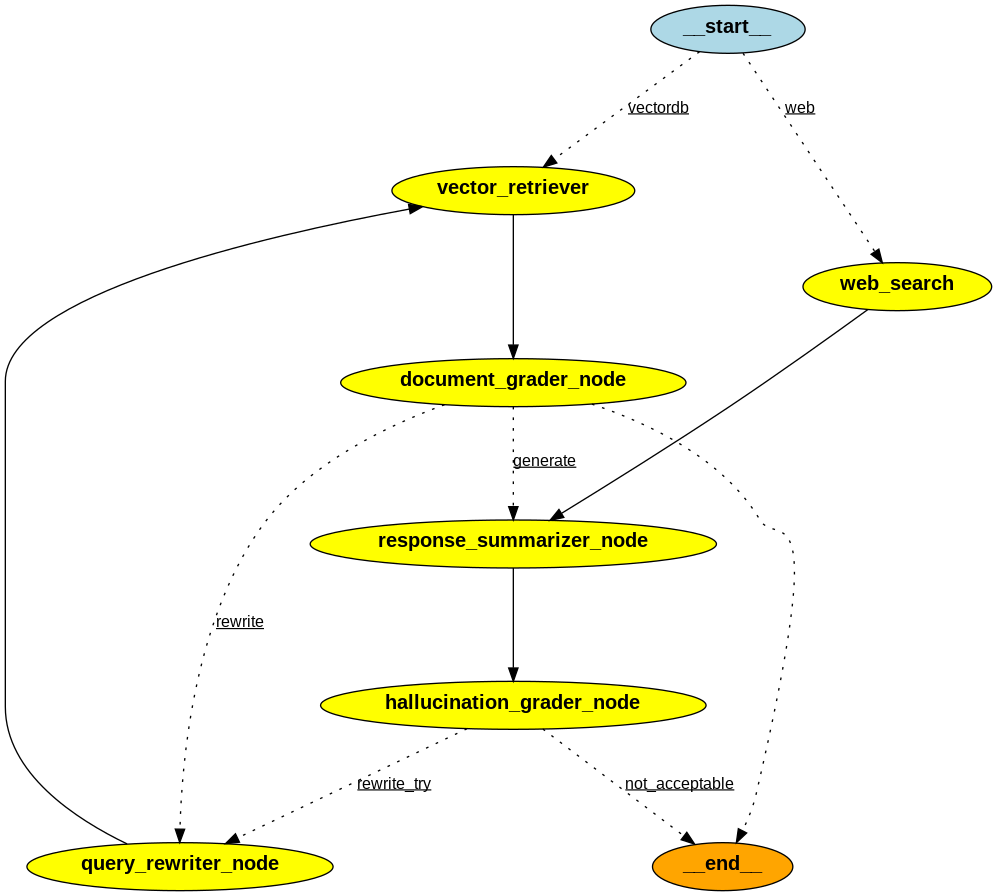

#### Next we will focus on Langgraph creation for the Adaptive RAG system
- Start with a query analysis (router) node to determine if the question is related to the index (vector DB) or not.
- If unrelated to the index, use a web search and generate an answer from web results.
- If related to the index, retrieve documents, grade them for relevance, and only proceed if relevant.
- If documents are not relevant, rewrite the question and retry retrieval.
- If relevant, generate an answer using the retrieved documents.
- Check the generated answer for hallucinations and score the answer and whether it answers the question.
- If hallucinations are detected or the answer is insufficient, loop back to regenerate (possibly after rewriting the question).
- If the answer is good and not hallucinated, return it as the final answer.
- The flow allows for adding more routes or optional nodes as needed.


##### Graph State
- Centralized data structure to track the current state of the graph

In [30]:
class GraphState(TypedDict):
    """
    A state in the graph representing a node with a specific type and content.
    """

    question: str
    documents: list[Document]
    rewritten_question: Optional[str]
    summary: str
    citations: list[str]
    grade_score: Optional[str]
    hallucination: Optional[str]
    response_score: Optional[float]
    grading_iteration: Optional[int]
    hallucination_iteration: Optional[int]

In [31]:
# Define the graph structure
GraphState(
    question="What are the potential benefits of investing in the financials sector under the new Republican administration",
    documents=[
        Document(
            page_content="The financials sector is expected to benefit from...",
            metadata={"source": "source1"},
        ),
        Document(
            page_content="Investing in the financials sector can lead to...",
            metadata={"source": "source2"},
        ),
    ],
    rewritten_question="What are the advantages of investing in the financials sector with the new Republican administration?",
    summary="The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities.",
    citations=[
        "Source 1: The financials sector is expected to benefit from...",
        "Source 2: Investing in the financials sector can lead to...",
    ],
    grade_score="fully supported",
    hallucination="no",
    response_score=0.95,
)

{'question': 'What are the potential benefits of investing in the financials sector under the new Republican administration',
 'documents': [Document(metadata={'source': 'source1'}, page_content='The financials sector is expected to benefit from...'),
  Document(metadata={'source': 'source2'}, page_content='Investing in the financials sector can lead to...')],
 'rewritten_question': 'What are the advantages of investing in the financials sector with the new Republican administration?',
 'summary': "The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities.",
 'citations': ['Source 1: The financials sector is expected to benefit from...',
  'Source 2: Investing in the financials sector can lead to...'],
 'grade_score': 'fully supported',
 'hallucination': 'no',
 'response_score': 0.95}

##### Query Router
- The query router is responsible for determining the appropriate path for a given query which is either related to the index or not.

In [32]:
class RouteQuery(BaseModel):
    source: Literal["vector_retriever", "web_search"] = Field(
        ...,
        description="The source using which the query needs to be answered, either vector_retriever or web_search.",
    )


structured_llm_router = llm.with_structured_output(schema=RouteQuery)

system_prompt_router = """ You are an expert in routing queries to the appropriate source. Your task is to determine the best source for answering the given query.
Instructions for choosing the source:
1. If the query is related to financial markets, investments, or economic trends, route it to the vector_retriever.
2. If the query is related to general knowledge or current events, route it to the web_search.
"""
router_prompt_template = ChatPromptTemplate(
    messages=[
        {"role": "user", "content": system_prompt_router},
        {
            "role": "human",
            "content": """Given the following query, determine the best source for answering it:{query}""",
        },
    ],
    input_variables=["query"],
)

In [33]:
question_router_chain = router_prompt_template | structured_llm_router

op = await question_router_chain.ainvoke(
    {
        "query": "What are the potential benefits of investing in the financials sector under the new Republican administration"
    }
)
print(op.source)
op = await question_router_chain.ainvoke({"query": "What is the capital of France?"})
print(op.source)

vector_retriever
web_search


##### Next we define the node for two major tools - vector_retriever and web_search

In [34]:
def vector_retriever(state: GraphState):
    """
    Function to retrieve documents from the vector store based on the question in the state using ensemble_retriever and save the documents in the state.
    """
    question = state["question"]
    documents = ensemble_retriever.invoke(question)

    return {"documents": documents, "question": question}

In [35]:
def web_search(state: GraphState):
    """
    Function to retrieve documents from the web search based on the question in the state using web_search_retriever and save the documents in the state.
    """
    question = state["question"]
    documents = web_search_retriever.invoke(question)
    lc_docs = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in documents
    ]

    return {"documents": lc_docs, "question": question}

In [36]:
# # test each node
# state = GraphState(
#     question="What are the potential benefits of investing in the financials sector under the new Republican administration",
#     documents=[],
#     rewritten_question="What are the advantages of investing in the financials sector with the new Republican administration?",
#     summary="The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities.",
#     citations=[
#         "Source 1: The financials sector is expected to benefit from...",
#         "Source 2: Investing in the financials sector can lead to...",
#     ],
# )
# state = vector_retriever(state)
# print(len(state["documents"]))
# print("***************")
# state = web_search(state)
# print(len(state["documents"]))

In [37]:
# test each node
state = GraphState(
    question="What are the potential benefits of investing in the financials sector under the new Republican administration",
    documents=[],
    rewritten_question="",
    summary="",
    citations=[],
)

op = vector_retriever(state)
# print(len(op["documents"]))

temp_content = "\n\n".join(
    [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(op["documents"])]
)
temp_source = "\n\n".join(
    [
        f"Source idx: {i} - {doc.metadata['source']}"
        for i, doc in enumerate(op["documents"])
    ]
)
temp_keyword = ",\n".join(
    [
        f"Keywords set: {i} - ({doc.metadata['keywords']})"
        for i, doc in enumerate(op["documents"])
    ]
)

print(temp_content)
print(temp_source)
print(temp_keyword)

Content idx: 0 - Nutmeg investor update: December 2024 - NutmegSkip to contentProductsProductsInvest for every stage for life and make the most of your tax allowances. Stocks and Shares ISAPersonal PensionLifetime ISAJunior ISAGeneral Investment AccountInvestment stylesInvestment stylesHave your money managed in a way that fits your goals and priorities.Fully ManagedThematic InvestingSmart AlphaSocially Responsible InvestingFixed AllocationAdviceFinancial advice and guidanceGet expert support to help you make the right investment choices.Free financial guidanceOur financial advice serviceRetirement adviceInvestment adviceConsolidation adviceLump sum adviceBook your free consultationTools and guidesTools and guidesSee how you could reach your goals with our calculators and how-to guides.ToolsSelf-employed tax calculatorCompound returns calculatorISA calculatorPension calculatorCapital Gains Tax calculatorGuidesInvesting for beginnersHow to retire at 55How to avoid the 60% tax trapWhat i

##### Grading Retrieved Documents
- The grading node evaluates the retrieved documents based on their relevance to the query with a binary grading system (relevant or not relevant).

In [38]:
class GradingDocuments(BaseModel):
    """
    A class to represent the grading of documents.
    """

    grade_score: Literal["full_relevance", "partial_relevance", "no_relevance"] = Field(
        ...,
        description="The relevance score of the documents, which can be full_relevance, partial_relevance, or no_relevance based on the content.",
    )

In [39]:
structured_llm_grader = llm.with_structured_output(schema=GradingDocuments)

In [40]:
system_prompt_grader = """
Task:
Assess the relevance of a retrieved document in answering the given user question.

Instructions:
1. Carefully read the user question and the retrieved document content.
2. Determine if the document contains information (keywords, facts, context, or semantics) directly related to the question.
3. Classify the document's relevance using one of the following categories:
   - full_relevance:
     The document contains key facts, figures, arguments, or contextual details that directly and comprehensively address the question.
   - partial_relevance:
     The document includes some relevant information but is incomplete, too general, or partially off-topic.
   - no_relevance:
     The document contains little to no meaningful connection to the question, or is entirely off-topic.
4. Base your decision on both semantic similarity and the presence of essential context or key information—not just superficial keyword overlap.
5. Do not include any additional explanation or commentary in the output.
6. Return only the relevance label using one of the following exact values: full_relevance, partial_relevance, no_relevance.

Input:
Question: <The user’s original question.>
Document Content: <The text content of the retrieved document.>
"""

In [41]:
grader_prompt_template = ChatPromptTemplate(
    messages=[
        {
            "role": "user",
            "content": system_prompt_grader,
        },
        {
            "role": "human",
            "content": """Given the following retrieved set of document{context} and user question {question}, grade the document as relevant or not""",
        },
    ],
    input_variables=["context", "question"],
    partial_variables={},
)

In [42]:
# Create the chain
grader_chain = grader_prompt_template | structured_llm_grader

In [45]:
temp_content

'Content idx: 0 - Nutmeg investor update: December 2024 - NutmegSkip to contentProductsProductsInvest for every stage for life and make the most of your tax allowances.\xa0Stocks and Shares ISAPersonal PensionLifetime ISAJunior ISAGeneral Investment AccountInvestment stylesInvestment stylesHave your money managed in a way that fits your goals and\xa0priorities.Fully ManagedThematic InvestingSmart AlphaSocially Responsible InvestingFixed AllocationAdviceFinancial advice and guidanceGet expert support to help you make the right investment choices.Free financial guidanceOur financial advice serviceRetirement adviceInvestment adviceConsolidation adviceLump sum adviceBook your free consultationTools and guidesTools and guidesSee how you could reach your goals with our calculators and how-to guides.ToolsSelf-employed tax calculatorCompound returns calculatorISA calculatorPension calculatorCapital Gains Tax calculatorGuidesInvesting for beginnersHow to retire at 55How to avoid the 60% tax tra

In [46]:
state["question"]

'What are the potential benefits of investing in the financials sector under the new Republican administration'

In [43]:
op = await grader_chain.ainvoke(
    {
        "context": temp_content,
        "question": state["question"],
    }
)

print(op.grade_score)

partial_relevance


In [44]:
# build some partially relevant content
partially_relevant_content = """ The republican administration has been focusing on various sectors, including technology and healthcare. The financials sector is also expected to benefit from the new policies. However, the impact on the financials sector is still uncertain and requires further analysis. """

random_document = """ Due to the war in Ukraine, the financial markets have been volatile. The russian invasion of Ukraine has led to increased energy prices and supply chain disruptions. Investors are advised to stay informed about the geopolitical situation and its potential impact on the markets. """

In [46]:
op = await grader_chain.ainvoke(
    {
        "context": partially_relevant_content,
        "question": state["question"],
    }
)
print(op.grade_score)

partial_relevance


##### Rewriting Queries for Better Retrieval
- The objetive of this node is to improve the chances of retrieving relevant documents by rewriting the query based on the grading results
- The rewriting process involves analyzing the original query and the retrieved documents to identify key terms and concepts that can be emphasized or clarified in the rewritten query.

In [47]:
class RewriteQuery(BaseModel):
    """
    A class to represent the rewriting of a query based on the original question and the retrieved documents.
    The rewritten query is generated to improve the relevance of the retrieved documents.
    """

    rewritten_query: str = Field(
        ...,
        description="The rewritten query based on the original question and the retrieved documents.",
    )

In [48]:
structured_query_rewriter = llm.with_structured_output(schema=RewriteQuery)

In [49]:
system_prompt_rewriter = """
Task:
Rewrite the user’s original query to improve its clarity, specificity, and relevance using insights from retrieved document keywords.

Instructions:
1. Read the original user question and the accompanying list of document keywords or key phrases.
2. Understand that these keywords represent the most important terms, entities, or concepts repeatedly emphasized across the retrieved documents.
   - These keywords reflect the dominant themes and signals in the documents that may align with or clarify the user's intent.
   - If the original question is vague or underspecified, these keywords help infer the probable topic, context, or direction of the intended question.
3. Rewrite the user question to make it more targeted, context-aware, and useful for downstream retrieval.
   - Incorporate relevant keywords that enhance clarity and relevance.
   - Add specificity or disambiguation where needed, based on the keyword context.
4. Ensure the rewritten query:
   - Preserves the original intent.
   - Is concise, focused, and aligned with the inferred direction from the keywords.
   - Maximizes relevance and retrieval quality.
5. Return only the final rewritten query without any explanation or formatting.

Input:
Original Question: <The user's original query.>
Document Keywords: <A list of significant keywords or phrases extracted from the retrieved documents. These reflect the dominant semantic signals that inform the likely intent of the user’s question.>
"""

In [50]:
rewrite_prompt_template = ChatPromptTemplate(
    messages=[
        {
            "role": "user",
            "content": system_prompt_rewriter,
        },
        {
            "role": "human",
            "content": """Given the following original question {question} and document keyword {context}, rewrite the question to improve its relevance and specificity.""",
        },
    ],
    input_variables=["context", "question"],
    partial_variables={},
)

In [51]:
rewrite_chain = rewrite_prompt_template | structured_query_rewriter

In [61]:
temp_keyword

'Keywords set: 0 - (Nutmeg investor update December 2024 US election Donald Trump equity markets emerging markets trade tariffs global trade US stocks economic growth bond markets investment implications),\nKeywords set: 1 - (Nutmeg investor update March 2025 US stocks European equities Chinese equities geopolitical news US macroeconomic signals consumer confidence financial markets investment outlook portfolio changes financial sector interest rates Republican administration),\nKeywords set: 2 - (Nutmeg investor update January 2025 stock markets bonds Federal Reserve interest rates inflation economic growth Santa Claus rally S&P 500 NASDAQ AI corporate earnings geopolitical uncertainties market volatility US equity emerging markets China Europe UK),\nKeywords set: 3 - (Nutmeg investor update December 2024 US election Donald Trump equity markets emerging markets trade tariffs global trade US stocks economic growth bond markets investment implications),\nKeywords set: 4 - (Nutmeg invest

In [52]:
op = rewrite_chain.invoke(
    {
        "context": temp_keyword,
        "question": "Benefits of investing in the financials sector under the new new administration",
    }
)
print(op)

rewritten_query='What are the benefits of investing in the financial sector under the new Republican administration, considering the recent US election, interest rates, economic growth, and geopolitical uncertainties?'


#### Generating Response from Relevant Documents
- In this step obj is to generate a response based on the retrieved documents and the rewritten query/user question.

In [53]:
class SummarizedResponse(BaseModel):
    """
    A class to represent the summarization of a response based on the original question and the retrieved documents.
    The summarized response is generated to provide a concise answer to the user's question.
    """

    summary: str = Field(
        ...,
        description="The summarized response based on the original question and the retrieved documents with proper headings and subheadings and bullet points. The summary should have introduction, body, and conclusion witthout citations.",
    )
    citation: str = Field(
        ...,
        description="The citation for the summarized response, indicating the source of the information used in the summary.",
    )


# get the structured llm
structured_llm_summarizer = llm.with_structured_output(schema=SummarizedResponse)

In [54]:
system_prompt_summarizer = """
Task:
Generate a focused and accurate summary that answers the user’s original question using the retrieved documents and their citations.

Instructions:
1. Carefully read the original question, the full content of the retrieved documents, and the provided citation references.
2. Identify the most important and relevant information that directly responds to the user’s question.
   - Prioritize facts, insights, or arguments that align semantically and contextually with the question.
3. Write a concise and coherent summary that:
   - Clearly addresses the user's question.
   - Captures the essence of the supporting documents.
   - Is easy to understand and free from ambiguity.
4. Do not include information that is irrelevant, vague, or unrelated to the question.
5. Integrate citations into the summary to support factual statements, referencing the sources in the same order as they appear in the retrieved documents.
6. Maintain a neutral and informative tone—avoid speculation or unsupported claims.
7. Only return the final summary. Do not include commentary or formatting outside the summary text.
8. The summary should be structured with proper headings and subheadings and bullet points and in string format.
9. The summary should always have and introduction, body and conclusion in the response.

Input:
Original Question: <The user’s original question.>
Retrieved Documents: <Raw text content from the retrieved documents.>
Citations: <Citation identifiers matching the order and origin of the retrieved documents.>
"""

In [55]:
summarizer_prompt_template = ChatPromptTemplate(
    messages=[
        {
            "role": "user",
            "content": system_prompt_summarizer,
        },
        {
            "role": "human",
            "content": """Given the following retrieved set of document{context}, citations {citation} and user question {question}, summarize the response to provide a concise answer to the user's question.""",
        },
    ],
    input_variables=["context", "question"],
    partial_variables={},
)

In [56]:
summarizer_chain = summarizer_prompt_template | structured_llm_summarizer

In [57]:
op = summarizer_chain.invoke(
    {
        "question": state["question"],
        "context": temp_content,
        "citation": temp_source,
    }
)

In [58]:
print(op.summary)
print(op.citation)

**Introduction**

Investing in the financials sector under the new Republican administration presents several potential benefits. This summary outlines the key reasons why the Nutmeg investment team has added a position in the financials sector to their portfolios.

**Body**

- **Economic Backdrop**: The US economy is growing at a steady pace, which is favorable for financial institutions. Banks are expected to expand their activities through increased lending as the economy grows.
- **Interest Rates**: Interest rates remain elevated but are off their peak. The Federal Reserve is expected to take a steady approach to interest rate adjustments, balancing inflation and growth pressures. Higher interest rates can increase the earnings potential for financial institutions, provided they do not constrain economic activity.
- **Deregulation**: There is a possibility of further deregulation under the new Republican administration. This could include the watering down or scrapping of proposed 

In [59]:
response = op.summary
print("Response:", response)

Response: **Introduction**

Investing in the financials sector under the new Republican administration presents several potential benefits. This summary outlines the key reasons why the Nutmeg investment team has added a position in the financials sector to their portfolios.

**Body**

- **Economic Backdrop**: The US economy is growing at a steady pace, which is favorable for financial institutions. Banks are expected to expand their activities through increased lending as the economy grows.
- **Interest Rates**: Interest rates remain elevated but are off their peak. The Federal Reserve is expected to take a steady approach to interest rate adjustments, balancing inflation and growth pressures. Higher interest rates can increase the earnings potential for financial institutions, provided they do not constrain economic activity.
- **Deregulation**: There is a possibility of further deregulation under the new Republican administration. This could include the watering down or scrapping of

In [60]:
temp_source

'Source idx: 0 - https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-december-2024\n\nSource idx: 1 - https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-march-2025\n\nSource idx: 2 - https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-january-2025\n\nSource idx: 3 - https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-december-2024\n\nSource idx: 4 - https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-february-2025\n\nSource idx: 5 - https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-january-2025'

#### Hallucination and Grading Response
- Check if the final response is hallucinated or not
- What is the evaluation score for the response

In [60]:
class CheckandGradeResponse(BaseModel):
    """
    A class to represent the grading of a response based on the original question and the summarized response.
    The grading is done to ensure the quality and relevance of the response.
    """

    hallucination: Literal["yes", "no"] = Field(
        ...,
        description="A binary score indicating whether the response contains hallucinations or not.",
    )

    response_score: float = Field(
        ...,
        description="A score indicating the quality of the response, ranging from 0 to 1 based on the relevance and precision of the information provided.",
    )


structured_llm_checker = llm.with_structured_output(schema=CheckandGradeResponse)

In [61]:
system_prompt_checker_grader = """
Task:
Evaluate whether the summarized response accurately and relevantly answers the original user question, based on the retrieved documents.

Instructions:
1. Carefully read the original user question, the summarized response, and the raw content of the retrieved documents.
2. Identify hallucinations in the summarized response:
   - A hallucination is any fabricated, inaccurate, or unsupported information not grounded in the retrieved documents.
   - This includes entities, facts, or claims that are either not present in or contradict the retrieved content.
3. Set the Hallucination flag to:
   - 'yes' if any hallucinated content is found.
   - 'no' if the response is fully supported by the retrieved documents.
4. Assign a numerical score between 0.0 and 1.0 based on the following:
   - Relevance: How well the summarized response answers the original question.
   - Precision: How factually accurate the summary is according to the retrieved documents.
   - Score 1.0 for responses that are fully relevant and precise.
   - Score 0.0 for responses that are entirely irrelevant, incorrect, or hallucinated.
   - Use intermediate values (e.g., 0.3, 0.6, 0.8) to reflect partially relevant or accurate responses.
5. If hallucination is 'yes', the score must be 0.0.
6. If hallucination is 'no', assign a score between 0.0 and 1.0 based on relevance and accuracy.
7. Do not include any explanation or justification.
8. Return only the following output format:
   Hallucination: <yes/no>
   Score: <float value between 0.0 and 1.0>

Input:
Original Question: <The original user question.>
Summarized Response: <The summarized response generated from the question and retrieved documents.>
Retrieved Documents: <The raw content of the retrieved documents used to generate the summary.>
"""

In [62]:
checker_grader_prompt_template = ChatPromptTemplate(
    messages=[
        {
            "role": "user",
            "content": system_prompt_checker_grader,
        },
        {
            "role": "human",
            "content": """Given the following summarized response {response} , raw content of the retrieved documents {context} and user question {question}, evaluate whether the summarized response accurately and relevantly answers the original user question.""",
        },
    ],
    input_variables=["response", "question", "context"],
    partial_variables={},
)

In [63]:
# Create the chain
checker_grader_chain = checker_grader_prompt_template | structured_llm_checker

In [64]:
# curate a random response
# response = "The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities because of Narendra Modi's policies."

In [65]:
# half precise response
response = "The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities because of the new policies."

In [66]:
op = checker_grader_chain.invoke(
    {
        "response": response,
        "question": state["question"],
        "context": temp_content,
    }
)
print(op.hallucination)
print(op.response_score)

yes
0.0


### Building the LangGraph

In [70]:
class GraphState(TypedDict):
    """
    A state in the graph representing a node with a specific type and content.
    """

    question: str
    documents: list[Document]
    rewritten_question: Optional[str]
    summary: str
    citations: list[str]
    grade_score: Optional[str]
    hallucination: Optional[str]
    response_score: Optional[float]
    grading_iteration: Optional[int]
    hallucination_iteration: Optional[int]

In [71]:
# Start the workflow
workflow = StateGraph(GraphState)

##### Tool Nodes

In [72]:
def vector_retriever(state: GraphState):
    """
    Function to retrieve documents from the vector store based on the question in the state using ensemble_retriever and save the documents in the state.
    """
    print("Vector Retriever")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for vector retriever:", question)
    documents = ensemble_retriever.invoke(question)

    return {"documents": documents, "question": question}

In [73]:
def web_search(state: GraphState):
    """
    Function to retrieve documents from the web search based on the question in the state using web_search_retriever and save the documents in the state.
    """
    print("Web Search")
    question = state["question"]
    documents = web_search_retriever.invoke(question)
    lc_docs = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in documents
    ]

    return {"documents": lc_docs, "question": question}

##### Adding the router node

In [74]:
def router_node(state: GraphState):
    """
    Function to route the question to the appropriate source based on the user's query.
    """
    print("Routing the question to the appropriate source...")
    question = state["question"]
    op = question_router_chain.invoke({"query": question})

    if op.source == "vector_retriever":
        print("Routing to vector_retriever...")
        return "vectordb"
    elif op.source == "web_search":
        print("Routing to web_search...")
        return "web"

In [75]:
# workflow.add_node(node="router_node", action=router_node)

In [76]:
###### Adding tool nodes

workflow.add_node(
    node="vector_retriever",
    action=vector_retriever,
)

workflow.add_node(
    node="web_search",
    action=web_search,
)

In [77]:
# build the first layer with conditonal edges
workflow.add_conditional_edges(
    source=START,
    path=router_node,
    path_map={"vectordb": "vector_retriever", "web": "web_search"},
)

##### Adding Document Grader Node

In [78]:
# def document_grader_node(state: GraphState):
#     """
#     Function to grade the retrieved documents based on their relevance to the user's question.
#     """
#     print("Grading the retrieved documents...")
#     question = state["question"]
#     documents = state["documents"]

#     only_content = "\n\n".join(
#         [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(documents)]
#     )

#     op = grader_chain.invoke(
#     {
#         "context": only_content,
#         "question": question,
#     }
#     )

#     grade_score = op.grade_score
#     print("Graded documents with score:", grade_score)

#     return {
#         "grade_score": grade_score,
#         "grading_iteration": 1 if "grading_iteration" not in state else state["grading_iteration"] + 1,

#     }

In [79]:
def document_grader_node(state: GraphState):
    """
    Grades the retrieved documents for relevance to the user's question.
    Optimized for clarity, robustness, and consistent state updates.
    """
    print("Grading the retrieved documents...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for grading:", question)
    documents = state.get("documents", [])

    only_content = "\n\n".join(
        f"Content idx: {i} - {getattr(doc, 'page_content', '')}"
        for i, doc in enumerate(documents)
    )

    op = grader_chain.invoke(
        {
            "context": only_content,
            "question": question,
        }
    )

    grade_score = getattr(op, "grade_score", None)
    print("Graded documents with score:", grade_score)

    grading_iteration = state.get("grading_iteration", 0) + 1

    return {
        "grade_score": grade_score,
        "grading_iteration": grading_iteration,
    }

In [80]:
def decide_to_generate_rewrite(state: GraphState):
    """
    Function to decide whether to generate a new query or rewrite the existing one based on the grading score.
    If grading_iteration crosses the limit, print a message.
    """
    grade_score = state.get("grade_score")
    grading_iteration = state.get("grading_iteration", 0)
    print("Grade score:", grade_score)
    print("Grading iteration:", grading_iteration)
    print("Deciding whether to generate or rewrite based on the grading score...")

    if grading_iteration > 2:
        print("Grading iteration exceeded the limit. Stopping further attempts.")
        return "generate"  # END can be used to stop the workflow
    if grade_score == "full_relevance":
        return "generate"
    elif grade_score == "partial_relevance":
        return "rewrite"
    elif grade_score == "no_relevance":
        return END

**Question on Grader Node**:
- What should be the ideal step if grading_iteration is not converging?

In [81]:
# adding node
workflow.add_node(
    node="document_grader_node",
    action=document_grader_node,
)
# adding normal edge
workflow.add_edge(
    start_key="vector_retriever",
    end_key="document_grader_node",
)

##### Query Rewriter Node

In [82]:
# # sameple graph state
# gst = GraphState(
#     question="What are the potential benefits of investing in the financials sector under the new Republican administration",
#     documents=[
#         Document(
#             page_content="The financials sector is expected to benefit from...",
#             metadata={"source": "source1"},
#         ),
#         Document(
#             page_content="Investing in the financials sector can lead to...",
#             metadata={"source": "source2"},
#         ),
#     ],
#     summary="The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities.",
#     citations=[
#         "Source 1: The financials sector is expected to benefit from...",
#         "Source 2: Investing in the financials sector can lead to...",
#     ],
#     grade_score="full_relevance",
#     rewritten_question="What are the advantages of investing in the financials sector with the new Republican administration?",
# )

In [83]:
# if "rewritten_question" not in gst:
#     print("rewritten_question not in gst")
#     print(gst["question"])

# else:
#     print("rewritten_question in gst")
#     print(gst["rewritten_question"])

In [84]:
# def query_rewriter_node(state: GraphState):
#     """
#     Function to rewrite the user's question based on the retrieved documents and their keywords.
#     """
#     print("Rewriting the user's question...")
#     question = state["question"]
#     documents = state["documents"]

#     only_keyword = ",\n".join(
#         [
#             f"Keywords set: {i} - ({doc.metadata['keywords']})"
#             for i, doc in enumerate(documents)
#         ]
#     )

#     op = rewrite_chain.invoke(
#         {
#             "context": only_keyword,
#             "question": question,
#         }
#     )

#     rewritten_question = op.rewritten_query
#     print("Rewritten question:", rewritten_question)

#     return {
#         "rewritten_question": rewritten_question,
#     }

In [85]:
def query_rewriter_node(state: GraphState):
    """
    Function to rewrite the user's question based on the retrieved documents and their keywords.
    Optimized for robustness and clarity.
    """
    print("Rewriting the user's question...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for rewriting:", question)
    documents = state.get("documents", [])

    only_keyword = ",\n".join(
        f"Keywords set: {i} - ({doc.metadata.get('keywords', '')})"
        for i, doc in enumerate(documents)
    )

    op = rewrite_chain.invoke(
        {
            "context": only_keyword,
            "question": question,
        }
    )

    rewritten_question = getattr(op, "rewritten_query", "")
    print("Rewritten question:", rewritten_question)

    return {
        "rewritten_question": rewritten_question,
    }

In [86]:
# add the node
workflow.add_node(
    node="query_rewriter_node",
    action=query_rewriter_node,
)
# add a reverse edge to retriever
workflow.add_edge(
    start_key="query_rewriter_node",
    end_key="vector_retriever",
)

##### Response Regeneration Node

In [87]:
# def response_summarizer_node(state: GraphState):
#     """
#     Function to summarize the response based on the user's question and the retrieved documents.
#     """
#     print("Summarizing the response...")
#     question = state["question"]
#     documents = state["documents"]

#     only_content = "\n\n".join(
#         [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(documents)]
#     )

#     only_citation = "\n\n".join(
#         [
#             f"Source idx: {i} - {doc.metadata['source']}"
#             for i, doc in enumerate(documents)
#         ]
#     )

#     op = summarizer_chain.invoke(
#         {
#             "context": only_content,
#             "question": question,
#             "citation": only_citation,
#         }
#     )

#     summary = op.summary
#     citation = op.citation

#     return {
#         "summary": summary,
#         "citation": citation
#     }

In [88]:
def response_summarizer_node(state: GraphState):
    """
    Function to summarize the response based on the user's question and the retrieved documents.
    Optimized for robustness and clarity.
    """
    print("Summarizing the response...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for summarization:", question)
    documents = state.get("documents", [])

    only_content = "\n\n".join(
        f"Content idx: {i} - {getattr(doc, 'page_content', '')}"
        for i, doc in enumerate(documents)
    )

    only_citation = "\n\n".join(
        f"Source idx: {i} - {doc.metadata.get('source', '')}"
        for i, doc in enumerate(documents)
    )

    op = summarizer_chain.invoke(
        {
            "context": only_content,
            "question": question,
            "citation": only_citation,
        }
    )

    summary = getattr(op, "summary", "")
    citation = getattr(op, "citation", "")

    return {"summary": summary, "citation": citation}

In [89]:
# add the node
workflow.add_node(
    node="response_summarizer_node",
    action=response_summarizer_node,
)

# add one edge to the summarizer from web_search
workflow.add_edge(
    start_key="web_search",
    end_key="response_summarizer_node",
)

##### start with grade score to function decide_to_generate_rewrite and then to the downstream

In [90]:
workflow.add_conditional_edges(
    source="document_grader_node",
    path=decide_to_generate_rewrite,
    path_map={
        "generate": "response_summarizer_node",
        "rewrite": "query_rewriter_node",
        END: END,
    },
)

##### Hallucination and grading node

In [91]:
# def hallucination_grader_node(state: GraphState):
#     """
#     Function to check for hallucinations in the summarized response and grade it.
#     """
#     print("Checking for hallucinations in the summarized response and grading it...")
#     question = state["question"]
#     summary = state["summary"]
#     documents = state["documents"]

#     only_content = "\n\n".join(
#         [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(documents)]
#     )

#     op = checker_grader_chain.invoke(
#         {
#             "response": summary,
#             "question": question,
#             "context": only_content,
#         }
#     )

#     hallucination = op.hallucination
#     repsonse_score = op.repsonse_score

#     return {
#         "hallucination": hallucination,
#         "repsonse_score": repsonse_score,
#         "hallucination_iteration": 1 if "hallucination_iteration" not in state else state["hallucination_iteration"] + 1,
#     }

# def decide_to_accept_reject(state: GraphState):
#     """
#     Function to decide whether to accept or reject the summarized response based on the grading score.
#     """
#     print("Deciding whether to accept or reject the summarized response based on the grading score...")
#     hallucination = state["hallucination"]
#     print("Hallucination:", hallucination)
#     repsonse_score = state["repsonse_score"]
#     print("Response score:", repsonse_score)


#     hallucination_iteration = state["hallucination_iteration"]
#     print("Hallucination iteration:", hallucination_iteration)

#     if hallucination_iteration > 2:
#         print("Hallucination iteration exceeded the limit. Rejecting the response.")
#         return "not_acceptable"

#     else:
#         if hallucination == "yes":
#             print("Hallucination detected in the response.")
#             return "not_acceptable"
#         else:
#             if repsonse_score >= 0.7:
#                 print("Response is acceptable. ")
#                 return "acceptable"
#             else:
#                 print("Response is not acceptable, so rewriting the question.")
#                 return "rewrite_try"

In [92]:
def hallucination_grader_node(state: GraphState):
    """
    Checks for hallucinations in the summarized response and grades it.
    """
    print("Checking for hallucinations in the summarized response and grading it...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for hallucination grading:", question)
    summary = state.get("summary", "")
    documents = state.get("documents", [])

    only_content = "\n\n".join(
        [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(documents)]
    )

    op = checker_grader_chain.invoke(
        {
            "response": summary,
            "question": question,
            "context": only_content,
        }
    )

    hallucination = getattr(op, "hallucination")
    response_score = getattr(op, "response_score")

    print("Hallucination:", hallucination)
    print("Response score:", response_score)

    hallucination_iteration = state.get("hallucination_iteration", 0) + 1

    return {
        "hallucination": hallucination,
        "response_score": response_score,
        "hallucination_iteration": hallucination_iteration,
    }

In [93]:
def decide_to_accept_reject(state: GraphState):
    """
    Decides whether to accept or reject the summarized response based on hallucination and grading score.
    """
    print(
        "Deciding whether to accept or reject the summarized response based on the grading score..."
    )
    hallucination = state.get("hallucination")
    response_score = state.get("response_score")
    hallucination_iteration = state.get("hallucination_iteration", 0)

    # print("Hallucination:", hallucination)
    # print("Response score:", response_score)
    print("Hallucination iteration:", hallucination_iteration)

    if hallucination_iteration > 2:
        print("Hallucination iteration exceeded the limit. Rejecting the response.")
        return "not_acceptable"
    if hallucination == "yes":
        print("Hallucination detected in the response.")
        return "not_acceptable"
    if response_score >= 0.7:
        print("Response is acceptable.")
        return "acceptable"
    print("Response is not acceptable, so rewriting the question.")
    return "rewrite_try"

In [94]:
# add the node after response summarizer
workflow.add_node(
    node="hallucination_grader_node",
    action=hallucination_grader_node,
)

# add the edge to the hallucination grader
workflow.add_edge(
    start_key="response_summarizer_node",
    end_key="hallucination_grader_node",
)

In [95]:
# add the conditional edges to decide to accept or reject
workflow.add_conditional_edges(
    source="hallucination_grader_node",
    path=decide_to_accept_reject,
    path_map={
        "acceptable": END,
        "not_acceptable": END,
        "rewrite_try": "query_rewriter_node",
    },
)

In [96]:
# compile the graph and check the graph
graph = workflow.compile()

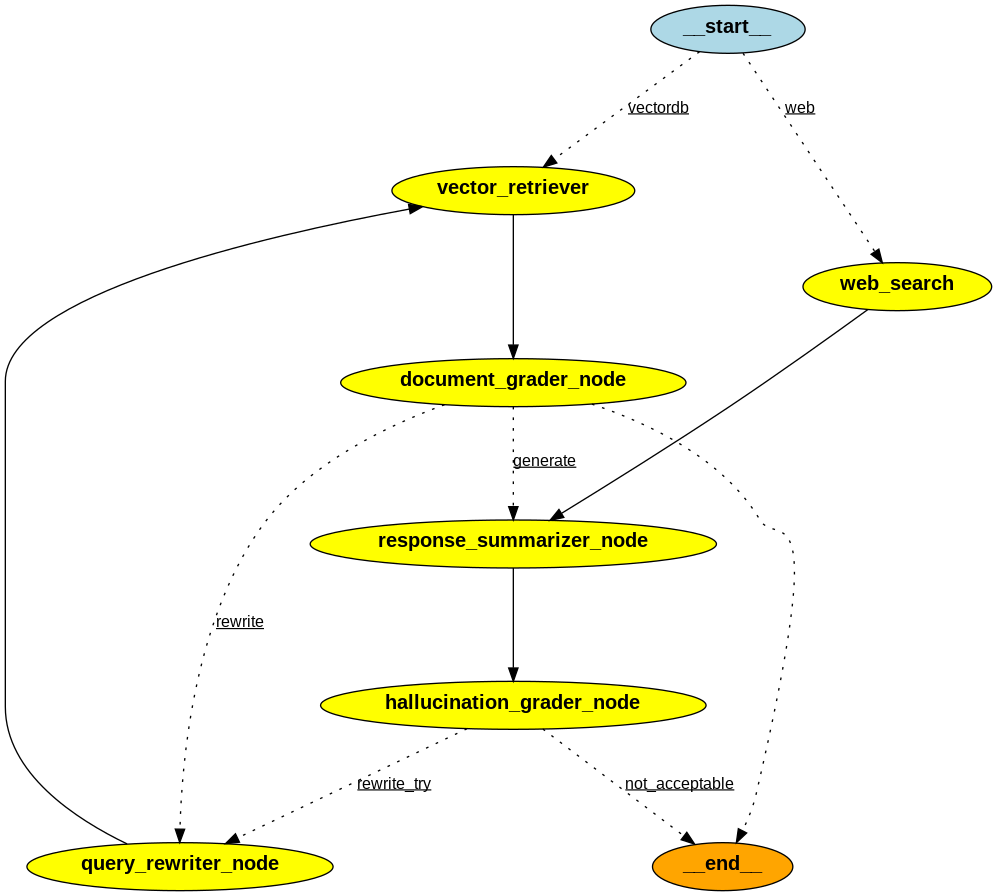

In [97]:
display(Image(graph.get_graph().draw_png()))

In [98]:
from pprint import pprint
from time import time

In [99]:
# create a time decorator

def timeit(func):
    """
    Decorator to measure the execution time of a function.
    """

    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        print(f"Execution time: {end_time - start_time:.2f} seconds")
        return result

    return wrapper

In [100]:
@timeit
def run_graph(graph, inputs):
    """
    Function to run the graph with the given inputs.
    """
    print("Running the graph...")

    # run the graph with the inputs

    op = graph.invoke(inputs)
    return op

In [101]:
inputs = {
    "question": "What are the potential benefits of investing in the financials sector under the new Republican administration",
}

# run the graph with the inputs
op = run_graph(graph, inputs)

Running the graph...
Routing the question to the appropriate source...
Routing to vector_retriever...
Vector Retriever
Question used for vector retriever: What are the potential benefits of investing in the financials sector under the new Republican administration
Grading the retrieved documents...
Question used for grading: What are the potential benefits of investing in the financials sector under the new Republican administration
Graded documents with score: full_relevance
Grade score: full_relevance
Grading iteration: 1
Deciding whether to generate or rewrite based on the grading score...
Summarizing the response...
Question used for summarization: What are the potential benefits of investing in the financials sector under the new Republican administration
Checking for hallucinations in the summarized response and grading it...
Question used for hallucination grading: What are the potential benefits of investing in the financials sector under the new Republican administration
Hallu

In [102]:
op

{'question': 'What are the potential benefits of investing in the financials sector under the new Republican administration',
 'documents': [Document(id='9bffbb5a-67b4-4dcb-8992-d9fba6fefc12', metadata={'source': 'https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-december-2024', 'title': 'Nutmeg investor update: December 2024 - Nutmeg', 'description': 'In November, investors saw the outcome of the US election as positive for US stocks, but it was a different story for emerging market equities.', 'language': 'en', 'summary': 'The Nutmeg investor update for December 2024 highlights the positive performance of US equity and bond markets following the re-election of Donald Trump, while emerging markets and European equities faced challenges. The update also discusses the potential impact of trade tariffs and a stronger US dollar on global trade and emerging markets.', 'keywords': 'Nutmeg investor update December 2024 US election Donald Trump equity markets bond markets emerging m

In [103]:
# bad question

inputs = {
    "question": "What is the reason for the financial markets to be volatile?",
}

op = run_graph(graph, inputs)

Running the graph...
Routing the question to the appropriate source...
Routing to vector_retriever...
Vector Retriever
Question used for vector retriever: What is the reason for the financial markets to be volatile?
Grading the retrieved documents...
Question used for grading: What is the reason for the financial markets to be volatile?
Graded documents with score: partial_relevance
Grade score: partial_relevance
Grading iteration: 1
Deciding whether to generate or rewrite based on the grading score...
Rewriting the user's question...
Question used for rewriting: What is the reason for the financial markets to be volatile?
Rewritten question: What are the reasons for financial market volatility, considering factors such as US elections, trade tariffs, interest rates, inflation, and geopolitical uncertainties?
Vector Retriever
Question used for vector retriever: What are the reasons for financial market volatility, considering factors such as US elections, trade tariffs, interest rates,

In [104]:
op

{'question': 'What are the reasons for financial market volatility, considering factors such as US elections, trade tariffs, interest rates, inflation, and geopolitical uncertainties?',
 'documents': [Document(id='9bffbb5a-67b4-4dcb-8992-d9fba6fefc12', metadata={'source': 'https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-december-2024', 'title': 'Nutmeg investor update: December 2024 - Nutmeg', 'description': 'In November, investors saw the outcome of the US election as positive for US stocks, but it was a different story for emerging market equities.', 'language': 'en', 'summary': 'The Nutmeg investor update for December 2024 highlights the positive performance of US equity and bond markets following the re-election of Donald Trump, while emerging markets and European equities faced challenges. The update also discusses the potential impact of trade tariffs and a stronger US dollar on global trade and emerging markets.', 'keywords': 'Nutmeg investor update December 2024 US 

In [ ]:
# inputs = {
#     "question": "What are the potential benefits of investing in the financials sector under the new Republican administration",
# }

# for output in graph.stream(inputs, stream_mode="values"):
#     for key, value in output.items():
#         pprint(f"Node '{key}':")
#         # Ensure 'generation' key exists
#         if "summary" in value:
#             pprint(value["summary"])
#             pprint(value["citation"])
#         else:
#             pprint("No generation found at this step.")
#     print("\n---\n")

# print(f"The final output is: {output}")
# print("\n---\n")

In [ ]:
# inputs = {
#     "question": "What are the potential causes of the war between Russia and Ukraine",
# }
# for output in graph.stream(inputs, stream_mode="values"):
#     for key, value in output.items():
#         pprint(f"Node '{key}':")
#         pprint(f"Value '{value}':")
#         # Ensure 'generation' key exists
#         if "summary" in value:
#             pprint(value["summary"])
#             pprint(value["citation"])
#         else:
#             pprint("No generation found at this step.")
#     print("\n---\n")

# print(f"The final output is: {output}")
# print("\n---\n")

This LangGraph workflow implements an Adaptive RAG (Retrieval-Augmented Generation) System with the following nodes and logic:

Router Node:

Receives the user question.
Uses an LLM-based router to decide if the question should be answered using the vector database (vectordb) or web search.
Routes to either the vector_retriever or web_search node.
Vector Retriever Node:

Retrieves relevant documents from the vector store using an ensemble retriever.
Passes the documents and question to the next node.
Web Search Node:

Retrieves relevant documents from the web using a search API.
Converts results into LangChain Document objects.
Passes the documents and question to the next node.
Document Grader Node:

Grades the relevance of the retrieved documents to the question using an LLM-based grader.
Increments a grading iteration counter.
Passes the grade score and iteration count to the next step.
Conditional Edge (decide_to_generate_rewrite):

If the documents are fully relevant or the grading iteration exceeds 2, proceeds to generate a response.
If partially relevant, rewrites the query and retries retrieval.
If not relevant, ends the workflow.
Query Rewriter Node:

Uses document keywords to rewrite the question for better retrieval.
Loops back to the vector retriever for another attempt.
Response Summarizer Node:

Summarizes the answer using the question and retrieved documents.
Produces a summary and citations.
Hallucination Grader Node:

Checks the summary for hallucinations and scores the response.
Increments a hallucination iteration counter.
Conditional Edge (decide_to_accept_reject):

If the response is acceptable (no hallucination, score ≥ 0.7), ends the workflow.
If not acceptable or hallucination iteration exceeds 2, ends the workflow.
If not acceptable but not hallucinated, rewrites the question and retries.

Summary:
The graph adaptively routes questions, retrieves and grades documents, rewrites queries if needed, summarizes responses, and checks for hallucinations. It loops through retrieval and rewriting until a high-quality, non-hallucinated answer is produced or a retry limit is reached, ensuring robust and accurate RAG-based question answering.



####################################################### END #######################################################